# <center>Shear Force and Bending Moment Diagram Calculator 
### <center>(working for statically determinate beams only)

In [1]:
%matplotlib inline

In [2]:
import math
import numpy as np
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected = True)

## 1. What are and used for shear force and bending moment diagram?

**Shear and bending moment diagrams** are analytical tools used in conjunction with structural analysis to help perform structural design by determining the value of shear force and bending moment at a given point of a structural element such as a beam. These diagrams can be used to easily determine the type, size, and material of a member in a structure so that a given set of loads can be supported without structural failure. Another application of shear and moment diagrams is that the deflection of a beam can be easily determined using either the moment area method or the conjugate beam method.

<hr>

## 2. Calculator construction

### Priniciple of Superposition

All calculations in this calculator are based on the Principle of Superposition. This means that the impact of multiple loads acting on a simply supported beam can be calculated as sum of those loads acting individually. 

N.B.: Principle of Superposition is valid ONLY for linear behavior of the construction. It can not be applied if there are occured non_linear plastic deformations in the structure.

###  Approach

1. Define a function that calculates  the reactions in the supports from a single point load
2. Construct a for-loop that cycles through each defined point load
3. In the loop calling the function from point 1
4. Calculating the reactions from each point load acting individually
5. Recording the results from the calculations
6. Using the Prinicple of Superposition accumulate impact from each point load to determine actual reactions

Calculator will be able to solve the beam and find the internal shear force and bending moment at each point of its span for point loads, point moments, uniformly distributed loads, linearly varying distributed loads (triangular loads)

<hr>

## 3. Calculator limitations and improving options

1. Limitations: <br>
    1.1. Assuming linear behavior of the structure <br>
    1.2. Applied only for statically determinate beams <br>
2. Improvements: <br>
    2.1. Extend functionality by adding rotating hinges <br>
    2.2. Extend functionality to solve internal torques and angles of twist <br>
    2.3. Adding more sophisticated analysis techniques such as finite element method

<hr>

## 4. Defining Test Beam

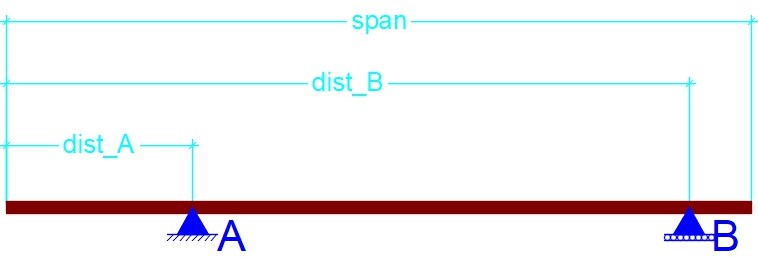

In [3]:
#Input span and force data

span = 12 #Beam span in meters
dist_A = 3 #Distance to left support from the beginning of the beam
dist_B = 11 #Distance to right support from the beginning of the beam

In [4]:
#Default force data (if none is defined below)

point_loads = np.array([[]]) #Point Forces defining [distance from the beginning, x_magnitude, y_magnitude]
point_moments = np.array([[]]) #Point Moments defining [distance from the beginning, magnitude]
distributed_loads = np.array([[]]) #Distributed Loads defining [distance to start, distance to end, magnitude]
linear_loads = np.array([[]]) #Distributed Loads with linearly varying intensity defining 
                              #[distance to start, distance to end, start magnitude, end magnitude]

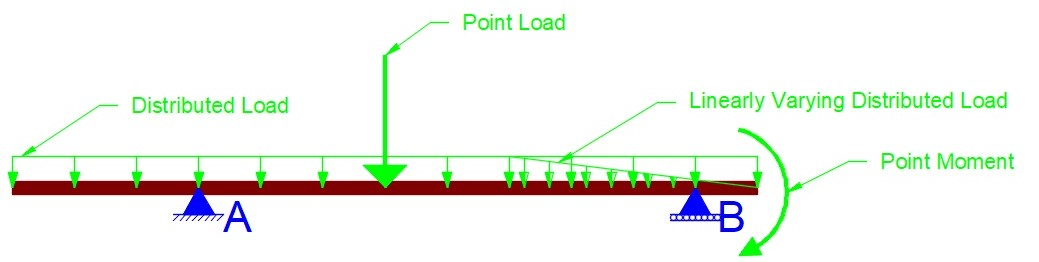

In [5]:
#Input Force Data

point_loads = np.array([[6, 0, -80]])
point_moments = np.array([[12, 30]])
distributed_loads = np.array([[0, 12, -10]])
linear_loads = np.array([[8, 12, -10, 0]])

<hr>

## 5. Reaction Calculation

All the calculations are based on the internal equilibrium state of each sub-structure. Sub-structures are defined by cuts in the structure on a locations of each data point to determine reactions in the supports.

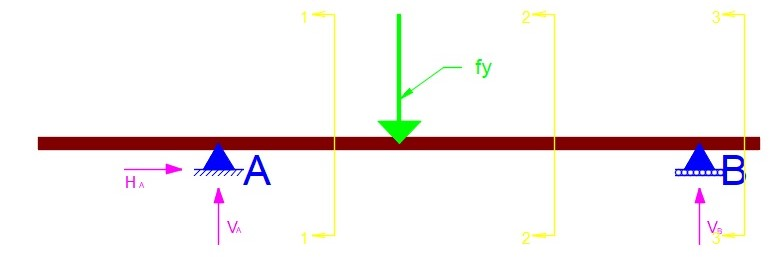

$$\sum H = 0 $$

$$\sum V = 0 $$

$$\sum M = 0 $$

Sum of all horizontal forces in the sub-structure should be equal to zero. <br>
Sum of all vertical forces in the sub-structure should be equal to zero. <br>
Sum of all moment forces in the sub-structure should be equal to zero.

<hr>

### Case 1:

$$dist\_A < x < dist\_p$$

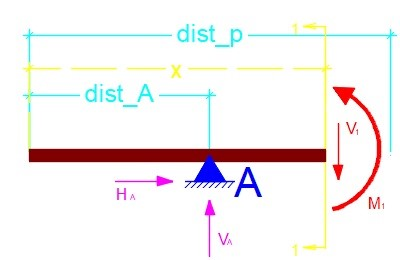

$$V_A - V_1 = 0$$

$$V_A(x - dist\_A) - M_1 = 0$$

<hr>

### Case 2:

$$dist\_p < x < dist\_B$$

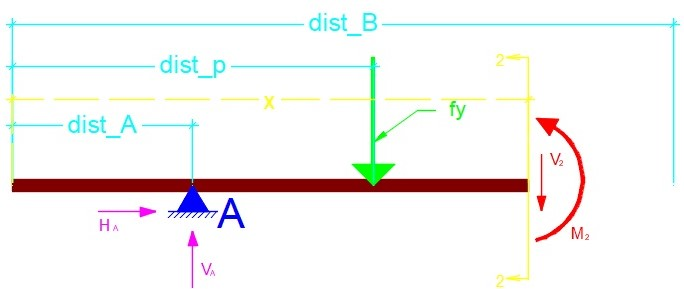

$$V_A - f_y -V_2 = 0$$

$$V_A(x - dist\_A) - f_y(x - dist\_p) - M_2 = 0$$

<hr>

### Case 3:

$$dist\_B < x < span$$

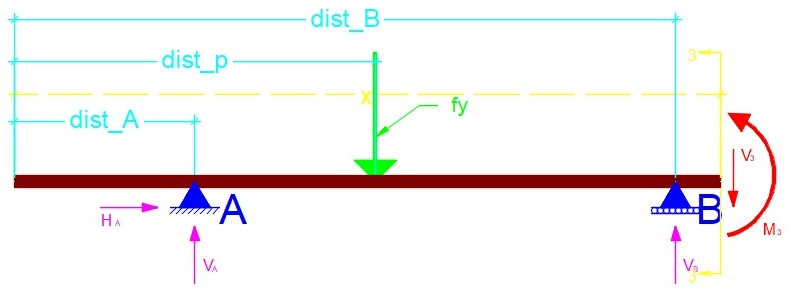

$$V_A - f_y + V_B - V_3 = 0$$

$$V_A(x - dist\_A) - f_y(x - dist\_p) + V_B(x - dist\_B) - M_3 = 0$$

**This approach is applied similarly and for all other type of loads**

In [6]:
#Defaults and initialisations

data_points = 10000 #Divide the span up into this number of data points
delta = span / data_points
X = np.arange(0, span + delta, delta) #Range of X-coordinates
number_of_point_loads = len(point_loads[0]) #Look if any point loads are defined
number_of_point_moments = len(point_moments[0]) #Look if any point moments are defined
number_of_distributed_loads = len(distributed_loads[0]) #Look if any uniformly distributed loads are defined
number_of_linear_loads = len(linear_loads[0]) #Look if any linearly varying distributed loads are defined

reactions = np.array([0.0, 0, 0])   #Reactions in the supports, defined as array of floats. 
                                    #Support A is pinned - Va and Ha; support B is roller - Vb.
shear_force = np.empty([0, len(X)]) #Shear forces at each data point
bending_moment = np.empty([0, len(X)]) #Shear forces at each data point

### Defining a function that calculates reactions due to point loads

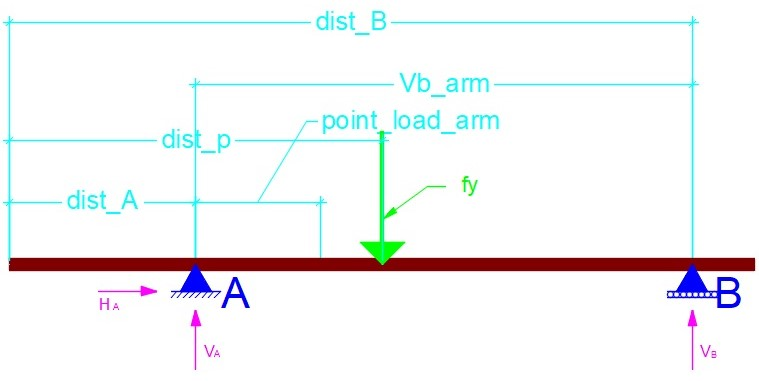

In [7]:
def reactions_point_loads(number):
    dist_p = point_loads[number, 0] #Distance from the beginning of the span to the point load
    fx = point_loads[number, 1] #Magnitude of the horizontal component of the point load
    fy = point_loads[number, 2] #Magnitude of the vertical component of the point load
    
    point_load_arm = dist_A - dist_p #Lever arm of point load about point A
    point_load_moment = fy * point_load_arm #Moment generated by the point load about point A - clockwise moments are positive
    Vb_arm = dist_B - dist_A #Lever arm of vertical reaction at point B about point A
    
    Vb = point_load_moment / Vb_arm #Vertical reaction at point B
    Va = -fy - Vb #Vertical reaction at point A
    Ha = -fx #Horizontal reaction at point A
    
    return Va, Ha, Vb

### Defining a function that calculates reactions due to point moments

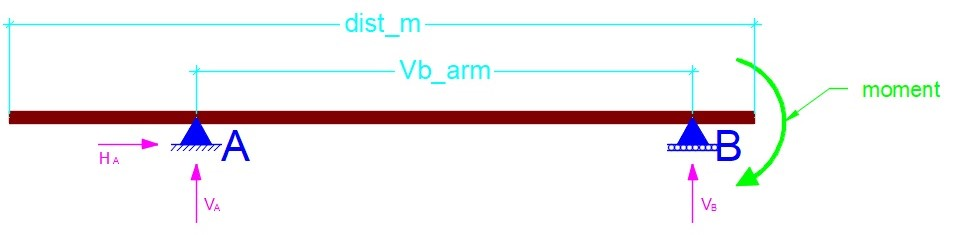

In [8]:
def reactions_point_moments(number):
    dist_m = point_moments[number, 0] #Distance from the beginning of the span to the point moment
    moment = point_moments[number, 1] #Magnitude of the point moment
    
    Vb_arm = dist_B - dist_A #Lever arm of vertical reaction at point B about point A
    Vb = moment / Vb_arm #Vertical reaction at point B
    Va = -Vb #Vertical reaction at point A
    
    return Va, Vb

### Defining a function that calculates reactions due to distributed loads

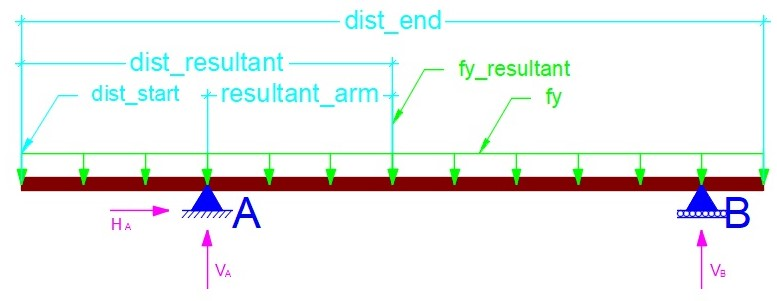

In [9]:
def reactions_distributed_loads(number):
    dist_start = distributed_loads[number, 0] #Distance from the beginning of the span to the beginning of the distributed load
    dist_end = distributed_loads[number, 1] #Distance from the beginning of the span to the end of the distributed load
    fy = distributed_loads[number, 2] 
    
    fy_resultant = fy * (dist_end - dist_start)
    dist_resultant = dist_start + 0.5 * (dist_end - dist_start)
    
    resultant_arm = dist_A - dist_resultant #Lever arm of resultant load about point A
    resultant_moment = fy_resultant * resultant_arm #Moment generated by the resultant load about point A - 
                                                    #lockwise moments are positive
    Vb_arm = dist_B - dist_A #Lever arm of vertical reaction at point B about point A
    
    Vb = resultant_moment / Vb_arm #Vertical reaction at point B
    Va = -fy_resultant - Vb #Vertical reaction at point A
    
    return Va, Vb    

### Defining a function that calculates reactions due to linearly varying distributed loads

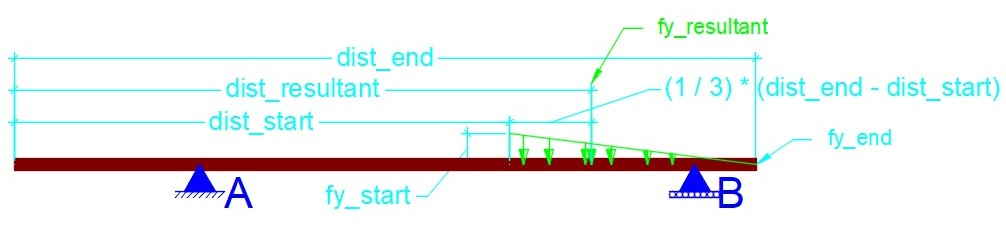

In [10]:
def reactions_linear_loads(number):
    dist_start = linear_loads[number, 0]
    dist_end = linear_loads[number, 1]
    fy_start = linear_loads[number, 2]
    fy_end = linear_loads[number, 3]
    
    #Determine location and magnitude of resultant force
    if abs(fy_start) > 0:
        fy_resultant = 0.5 * fy_start * (dist_end - dist_start)
        dist_resultant = dist_start + (1 / 3) * (dist_end - dist_start)
    else:
        fy_resultant = 0.5 * fy_end * (dist_end - dist_start)
        dist_resultant = dist_start + (2 / 3) * (dist_end - dist_start)
        
    resultant_arm = dist_A - dist_resultant #Lever arm of resultant load about point A
    resultant_moment = fy_resultant * resultant_arm #Moment generated by the resultant load about point A - 
                                                    #lockwise moments are positive
    Vb_arm = dist_B - dist_A #Lever arm of vertical reaction at point B about point A
    
    Vb = resultant_moment / Vb_arm #Vertical reaction at point B
    Va = -fy_resultant - Vb #Vertical reaction at point A
    
    return Va, Vb 

### Cycling through all defined point loads and determine reactions

In [11]:
point_load_result = np.empty([0, 3]) # Defining an empty np-array with 0 rows and 3 columns, to store resulting reactions
if number_of_point_loads > 0:
    for number, point_load in enumerate(point_loads):
        Va, Ha, Vb = reactions_point_loads(number) # Calculating reactions
        point_load_result = np.append(point_load_result, [np.array([Va, Ha, Vb])], axis = 0) #Stroring actual reaction 
                                                                                             #for each point load
         
        #Add reactions
        reactions[0] += Va
        reactions[1] += Ha
        reactions[2] += Vb

### Cycling through all defined point moments and determine reactions

In [12]:
point_moment_result = np.empty([0, 2])

if number_of_point_moments > 0:
    for number, point_moment in enumerate(point_moments):
        Va, Vb = reactions_point_moments(number)
        point_moment_result = np.append(point_moment_result, [np.array([Va, Vb])], axis = 0) #Stroring actual reaction 
                                                                                             #for each point moment
          
        #Add reactions
        reactions[0] += Va
        reactions[2] += Vb
         

### Cycling through all distributed loads and determine reactions

In [13]:
distributed_load_result = np.empty([0, 2]) # Defining an empty np-array with 0 rows and 2 columns, to store resulting reactions
if number_of_distributed_loads > 0:
    for number, point_load in enumerate(distributed_loads):
        Va, Vb = reactions_distributed_loads(number) # Calculating reactions
        distributed_load_result = np.append(distributed_load_result, [np.array([Va, Vb])], axis = 0) #Stroring actual reaction 
                                                                                                     #for each point load
         
        #Add reactions
        reactions[0] += Va
        reactions[2] += Vb

### Cycling through all linearly varying distributed loads and determine reactions

In [14]:
linear_load_result = np.empty([0, 2])
if number_of_linear_loads > 0: 
    for number, point_load in enumerate(linear_loads):
        Va, Vb = reactions_linear_loads(number) # Calculating reactions
        linear_load_result = np.append(linear_load_result, [np.array([Va, Vb])], axis = 0) #Stroring actual reaction 
                                                                                                     #for each point load
        #Add reactions
        reactions[0] += Va
        reactions[2] += Vb

<hr>

## 6. Shear and Moment Calculation

### Defining a function that calculates shear forces and bending moments due to a point loads

In [15]:
def shear_moment_point_load(number):
    dist_p = point_loads[number, 0] #Distance from the beginning of the span to the point load
    fy = point_loads[number, 2] #Magnitude of the vertical component of the point load
    Va = point_load_result[number, 0] #Vertical reaction at point A
    Vb = point_load_result[number, 2] #Vertical reaction at point B
    
    #Cycling through the structure and calculate the shear force and bending moment at each point
    Shear = np.zeros(len(X)) #Initializing a container to store all shear force data for current point load
    Moment = np.zeros(len(X)) #Initializing a container to store all bending moment force data for current point load
    
    for index, point_dist in enumerate(X):
        shear = 0 #Initializing the shear force for current point
        moment = 0 #Initializing the bending moment for current point
        
        if point_dist > dist_A: #Calculating shear and moment due to reaction at point A
            shear += Va
            moment -= Va * (point_dist - dist_A)
            
        if point_dist > dist_B: #Calculating shear and moment due to reaction at point B
            shear += Vb
            moment -= Vb * (point_dist - dist_B)
            
        if point_dist > dist_p: #Calculating shear and moment due to point load
            shear += fy
            moment -= fy * (point_dist - dist_p)
        
        #Storing shear and moment for current location
        Shear[index] = shear
        Moment[index] = moment
        
    return Shear, Moment 

### Defining a function that calculates shear forces and bending moments due to a point moments

In [16]:
def shear_moment_point_moment(number):
    dist_m = point_moments[number, 0] #Distance from the beginning of the span to the point moment
    moment_magn = point_moments[number, 1] #Magnitude of the point moment
    Va = point_moment_result[number, 0] #Vertical reaction at point A
    Vb = point_moment_result[number, 1] #Vertical reaction at point B  
    
     
    #Cycling through the structure and calculate the shear force and bending moment at each point
    Shear = np.zeros(len(X)) #Initializing a container to store all shear force data for current point moment
    Moment = np.zeros(len(X)) #Initializing a container to store all bending moment force data for current point moment
    
    for index, point_dist in enumerate(X):
        shear = 0 #Initializing the shear force for current point
        moment = 0 #Initializing the bending moment for current point
        
        if point_dist > dist_A: #Calculating shear and moment due to reaction at point A
            shear += Va
            moment -= Va * (point_dist - dist_A)
            
        if point_dist > dist_B: #Calculating shear and moment due to reaction at point B
            shear += Vb
            moment -= Vb * (point_dist - dist_B)
            
        if point_dist > dist_m: #Calculating moment influence of point moment, with no effect on the shear
            moment -= moment_magn
        
        #Storing shear and moment for current location
        Shear[index] = shear
        Moment[index] = moment
        
    return Shear, Moment 

### Defining a function that calculates shear forces and bending moments due to a distributed loads

In [17]:
def shear_moment_distributed_load(number):
    dist_start = distributed_loads[number, 0] #Distance from the beginning of the span to the beginning of the distributed load
    dist_end = distributed_loads[number, 1] #Distance from the beginning of the span to the end of the distributed load
    fy = distributed_loads[number, 2]
    Va = distributed_load_result[number, 0] #Vertical reaction at point A
    Vb = distributed_load_result[number, 1] #Vertical reaction at point B
    
    #Cycling through the structure and calculate the shear force and bending moment at each point
    Shear = np.zeros(len(X)) #Initializing a container to store all shear force data for current distributed load
    Moment = np.zeros(len(X)) #Initializing a container to store all bending moment force data for current distributed load
    
    for index, point_dist in enumerate(X):
        shear = 0 #Initializing the shear force for current point
        moment = 0 #Initializing the bending moment for current point
        
        if point_dist > dist_A: #Calculating shear and moment due to reaction at point A
            shear += Va
            moment -= Va * (point_dist - dist_A)
            
        if point_dist > dist_B: #Calculating shear and moment due to reaction at point B
            shear += Vb
            moment -= Vb * (point_dist - dist_B)
            
        if point_dist > dist_start and point_dist <= dist_end: #Calculating shear and moment due to point load
            shear += fy * (point_dist - dist_start)
            moment -= fy * (point_dist - dist_start) * 0.5 * (point_dist - dist_start)  
        elif point_dist > dist_end:
            shear += fy * (dist_end - dist_start)
            moment -= fy * (dist_end - dist_start) * (point_dist - dist_start - 0.5 * (dist_end - dist_start))
        
        #Storing shear and moment for current location
        Shear[index] = shear
        Moment[index] = moment
        
    return Shear, Moment 

### Defining a function that calculates shear forces and bending moments due to a linearly varying distributed loads 

In [18]:
def shear_moment_linear_load(number):
    dist_start = linear_loads[number, 0]
    dist_end = linear_loads[number, 1]
    fy_start = linear_loads[number, 2]
    fy_end = linear_loads[number, 3]
    
    Va = linear_load_result[number, 0] #Vertical reaction at point A
    Vb = linear_load_result[number, 1] #Vertical reaction at point B
    
    Shear = np.zeros(len(X)) #Initializing a container to store all shear force data for current linearly varying distributed load
    Moment = np.zeros(len(X)) #Initializing a container to store all bending moment force data for current linearly varying distributed load
    
    for index, point_dist in enumerate(X):
        shear = 0 #Initializing the shear force for current point
        moment = 0 #Initializing the bending moment for current point
        
        if point_dist > dist_A: #Calculating shear and moment due to reaction at point A
            shear += Va
            moment -= Va * (point_dist - dist_A)
            
        if point_dist > dist_B: #Calculating shear and moment due to reaction at point B
            shear += Vb
            moment -= Vb * (point_dist - dist_B)
            
        if point_dist > dist_start and point_dist <= dist_end:
            if abs(fy_start) > 0:
                dist_base = point_dist - dist_start #Base of the triangular load distribution
                fy_cut = fy_start - dist_base * (fy_start / (dist_end - dist_start)) #Magnitude of the linearly distributed load at the cut
                R1 = 0.5 * dist_base * (fy_start - fy_cut) # Magnitude of the resultant force for the triangular portion of the load
                R2 = dist_base * fy_cut # Magnitude of the resultant force for the constant portion of the load
                shear += R1 + R2
                moment -= R1 * (2 / 3) * dist_base + R2 * (dist_base / 2) 
            else:
                dist_base = point_dist - dist_start
                fy_cut = fy_end * (dist_base / (dist_end - dist_start))
                R = 0.5 * dist_base * fy_cut
                shear += R 
                moment -= R * (dist_base / 3)
        elif point_dist > dist_end:
            if abs(fy_start) > 0:
                R = 0.5 * fy_start * (dist_end - dist_start)
                dist_R = dist_start + (1 / 3) * (dist_end - dist_start)
                shear += R
                moment -= R * (point_dist - dist_R)
            else:
                R = 0.5 * fy_end * (dist_end - dist_start)
                dist_R = dist_start + (2 / 3) * (dist_end - dist_start)
                shear += R
                moment -= R * (point_dist - dist_R)
                
        #Storing shear and moment for current location
        Shear[index] = shear
        Moment[index] = moment
        
    return Shear, Moment 

### Cycling through all point loads and determine shear and moment

In [20]:
if  number_of_point_loads > 0:
    for number, point_load in enumerate(point_loads):
        Shear, Moment = shear_moment_point_load(number)
        shear_force = np.append(shear_force, [Shear], axis = 0) #Storing shear force for each point load
        bending_moment = np.append(bending_moment, [Moment], axis = 0) #Stroring bending moment for each point load

### Cycling through all point moments and determine shear and moment

In [21]:
if number_of_point_moments > 0:
    for number, point_moment in enumerate(point_moments):
        Shear, Moment = shear_moment_point_moment(number)
        shear_force = np.append(shear_force, [Shear], axis = 0) #Storing shear force for each point moment
        bending_moment = np.append(bending_moment, [Moment], axis = 0) #Stroring bending moment for each point moment

### Cycling through all distributed loads and determine shear and moment

In [22]:
if  number_of_distributed_loads > 0:
    for number, distributed_load in enumerate(distributed_loads):
        Shear, Moment = shear_moment_distributed_load(number)
        shear_force = np.append(shear_force, [Shear], axis = 0) #Storing shear force for each distributed load
        bending_moment = np.append(bending_moment, [Moment], axis = 0) #Stroring bending moment for each distributed load

### Cycling through all linearly varying distributed loads and determine shear and moment

In [23]:
if number_of_linear_loads > 0:
    for number, linear_load in enumerate(linear_loads):
        Shear, Moment = shear_moment_linear_load(number)
        shear_force = np.append(shear_force, [Shear], axis = 0) #Storing shear force for each linearly varying distributed load
        bending_moment = np.append(bending_moment, [Moment], axis = 0) #Stroring bending moment for each linearly varying distributed load

<hr>

## 7. Plotting and Printing

### Reactions results:

In [24]:
print("The vertical reaction at point A is {one} kN".format(one = round(reactions[0], 3)))
print("The horizontal reaction at point A is {one} kN".format(one = round(reactions[1], 3)))
print("The vertical reaction at point B is {one} kN".format(one = round(reactions[2], 3)))

The vertical reaction at point A is 125.417 kN
The horizontal reaction at point A is 0.0 kN
The vertical reaction at point B is 94.583 kN


In [25]:
#Define the layout object
layout = go.Layout(
            title = {"text": "Shear Force Diagram",
                    "y": 0.85,
                    "x": 0.5,
                    "xanchor": "center",
                    "yanchor": "top"},
            yaxis = dict(title = "Shear Force [kN]"),
            xaxis = dict(title = "Distance [m]", range = [-1, span + 1]),
            showlegend = False
                    )

line = go.Scatter(
        x = X,
        y = sum(shear_force),
        mode = "lines",
        name = "Shear Force",
        fill = "tonexty",
        line_color = "red",
        fillcolor = "rgba(255, 0, 0, 0.1)"
                    )

axis = go.Scatter(
        x = [0, span],
        y = [0, 0],
        mode = "lines",
        line_color = "black"
                    )

#Generating and showing the diagram
diag = go.Figure(data = [line, axis], layout = layout)

py.offline.iplot(diag)

In [26]:
#Define the layout object
layout = go.Layout(
            title = {"text": "Bending Moment Diagram",
                    "y": 0.85,
                    "x": 0.5,
                    "xanchor": "center",
                    "yanchor": "top"},
            yaxis = dict(title = "Bending Moment [kNm]",
            autorange = "reversed"),
            xaxis = dict(title = "Distance [m]", range = [-1, span + 1]),
            showlegend = False
                    )

line = go.Scatter(
        x = X,
        y = -sum(bending_moment),
        mode = "lines",
        name = "Bending Moment",
        fill = "tonexty",
        line_color = "blue",
        fillcolor = "rgba(0, 0, 255, 0.1)"
                    )

axis = go.Scatter(
        x = [0, span],
        y = [0, 0],
        mode = "lines",
        line_color = "black"
                    )

#Generating and showing the diagram
diag = go.Figure(data = [line, axis], layout = layout)

py.offline.iplot(diag)

<hr>

## 8.  Comparison to other online calculator

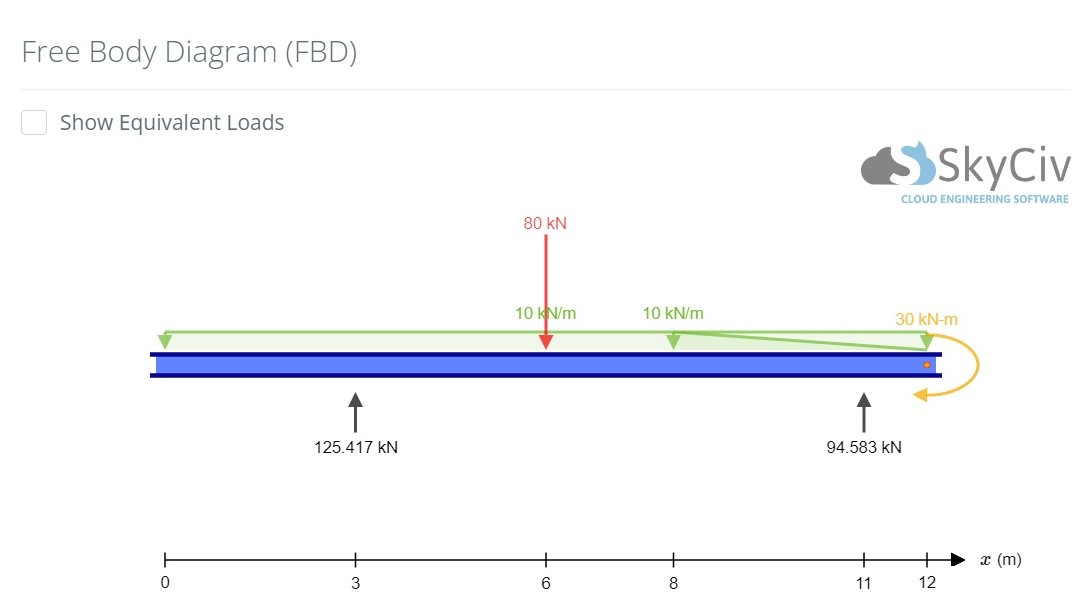

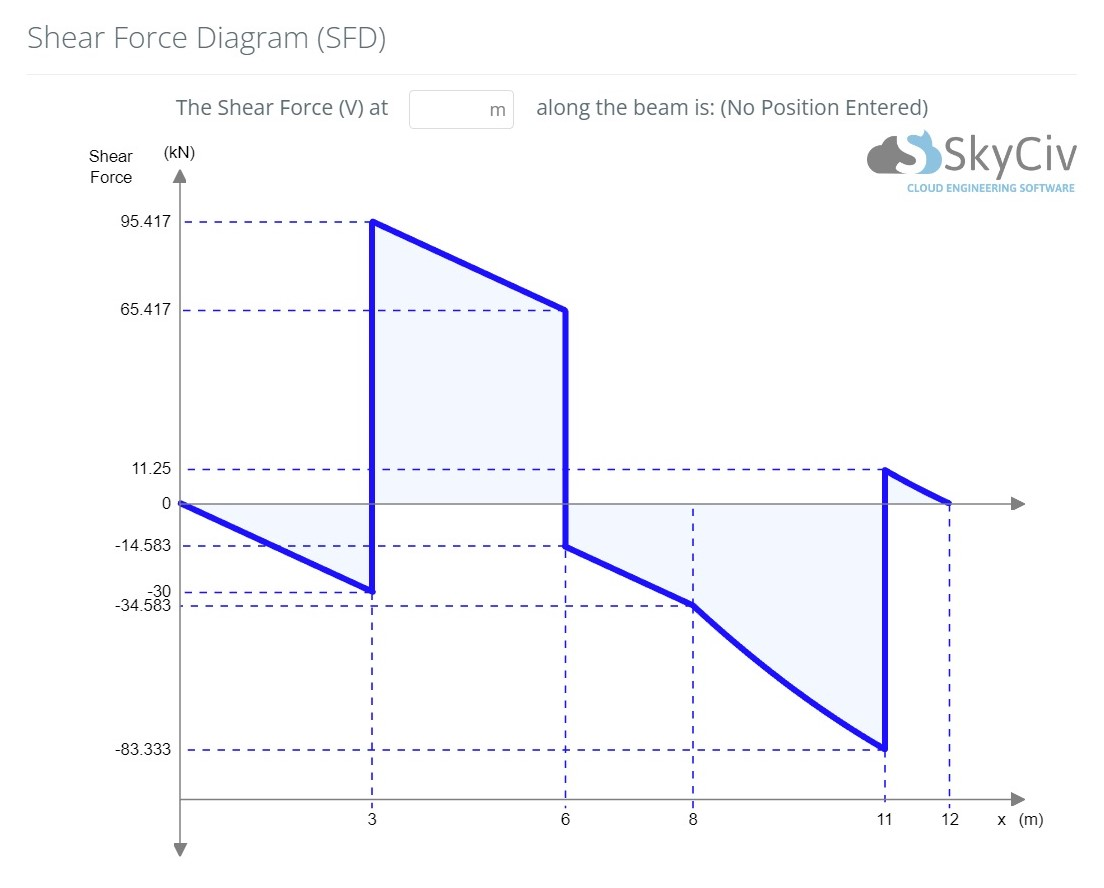

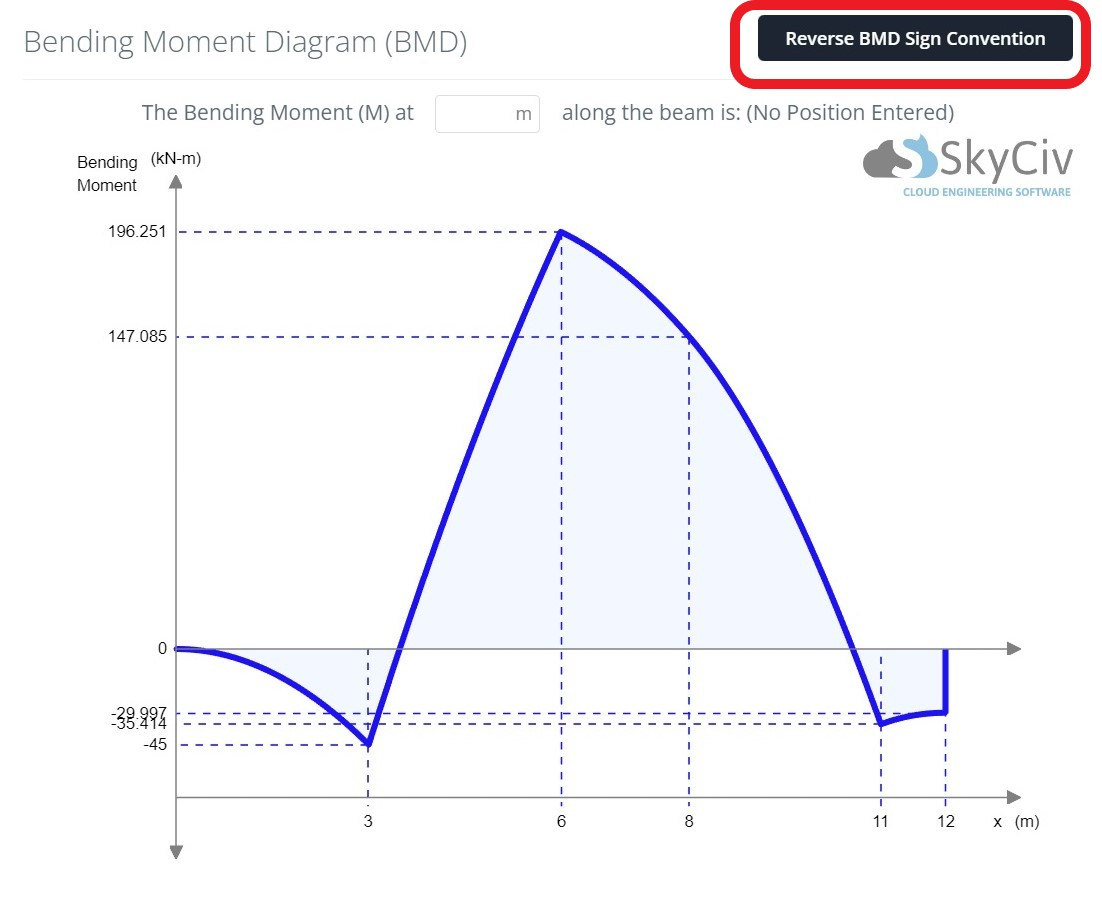

**Note: Bending Moment Diagram from SkyCiv is upside-down. Its just matter of convention where the positive moments will be displayed - above or below the zero line.**

<hr>

## 9. Resoureces:
**[DegreeTutors](https://www.degreetutors.com/)** <br>
**[Wikipedia](https://www.wikipedia.org/)** <br>
**[SkyCiv](https://skyciv.com/free-beam-calculator/)**